#Overview
This notebook focuses on implementing DINO (Distillation with No Labels) for self-supervised learning and using Grad-CAM++ for model interpretability. It demonstrates:

DINO Training:

Train a self-supervised model using dual ResNet-50 networks (student and teacher) and momentum-based embedding alignment.
Leverage data augmentations and distillation loss for label-free learning.

Grad-CAM++ Visualization:

Interpret model predictions by highlighting image regions critical to learned features.
Visualize class activation maps for better understanding of model focus.

#Installing necessary packages for DINO Training

In [ ]:
!pip install pytorch_lightning
!pip install lightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 834.9/834.9 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.8 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=d897dbfff3bf39bee815b87910b5464344d0307b6e2862e78a48e3042cb8343b
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


#Importing lightning and lightly packages for DINO training

In [ ]:
import copy
import pytorch_lightning as pl
import torch
import torchvision
from torch import nn
from lightly.loss import DINOLoss
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.dino_transform import DINOTransform
from lightly.utils.scheduler import cosine_schedule

In [ ]:
class DINO(pl.LightningModule):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet50()
        backbone = nn.Sequential(*list(resnet.children())[:-1])
        input_dim = 2048
        # instead of a resnet you can also use a vision transformer backbone as in the
        # original paper (you might have to reduce the batch size in this case):
        #backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=False)
        input_dim = backbone.embed_dim

        self.student_backbone = backbone
        self.student_head = DINOProjectionHead(
            input_dim, 512, 64, 2048, freeze_last_layer=1
        )
        self.teacher_backbone = copy.deepcopy(backbone)
        self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
        deactivate_requires_grad(self.teacher_backbone)
        deactivate_requires_grad(self.teacher_head)
        self.criterion = DINOLoss(output_dim=2048, warmup_teacher_temp_epochs=5)

    def forward(self, x):
        y = self.student_backbone(x).flatten(start_dim=1)
        z = self.student_head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

    def training_step(self, batch, batch_idx):
        momentum = cosine_schedule(self.current_epoch, 10, 0.996, 1)
        update_momentum(self.student_backbone, self.teacher_backbone, m=momentum)
        update_momentum(self.student_head, self.teacher_head, m=momentum)
        views = batch[0]
        views = [view.to(self.device) for view in views]
        global_views = views[:2]
        teacher_out = [self.forward_teacher(view) for view in global_views]
        student_out = [self.forward(view) for view in views]
        loss = self.criterion(teacher_out, student_out, epoch=self.current_epoch)
        return loss

    def on_after_backward(self):
        self.student_head.cancel_last_layer_gradients(current_epoch=self.current_epoch)

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=0.001)
        return optim


model = DINO()

transform = DINOTransform()
# we ignore object detection annotations by setting target_transform to return 0
dataset = torchvision.datasets.VOCDetection(
    "datasets/pascal_voc",
    download=True,
    transform=transform,
    target_transform=lambda t: 0,
)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

# Train with DDP and use Synchronized Batch Norm for a more accurate batch norm
# calculation. Distributed sampling is also enabled with replace_sampler_ddp=True.
trainer = pl.Trainer(
    max_epochs=10,
    devices="auto",
    accelerator="gpu",
    sync_batchnorm=True
)
trainer.fit(model=model, train_dataloaders=dataloader)

Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip


100%|██████████| 1999639040/1999639040 [01:32<00:00, 21510661.63it/s]


Extracting datasets/pascal_voc/VOCtrainval_11-May-2012.tar to datasets/pascal_voc


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type               | Params
-------------------

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


##Installing packages for implementing GradCAM

In [ ]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00


##Importing packages for visualizing GradCAM

In [ ]:
import plotly.io as pio
import json
import torch
from torchvision import models, transforms
from PIL import Image
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet50
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

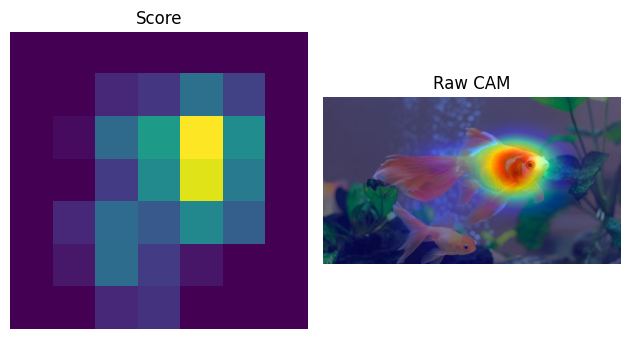

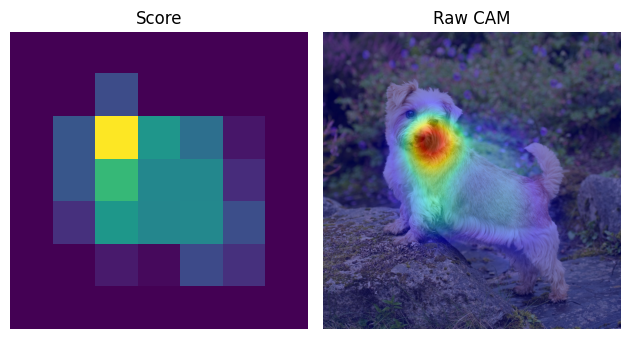

In [ ]:
model = resnet50(pretrained=False)
model.fc = torch.nn.Identity()
#Download DINO-pretrained model from the URL
state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/dino_resnet50_pretrain/dino_resnet50_pretrain.pth",map_location="cpu",)
#Load weights into ResNet model
model.load_state_dict(state_dict)
model.eval()
def display_attention(img_path):
  # Get your input
  img = read_image(img_path)
  # Preprocess it for your chosen model
  input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  with SmoothGradCAMpp(model,target_layer='layer4') as cam_extractor:
    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    # Visualize the raw CAM
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
  plt.subplot(1, 2, 1)
  plt.imshow(activation_map[0].squeeze(0).numpy())  # Display the raw CAM
  plt.title('Score')
  plt.axis('off')
  plt.tight_layout()
  # Display the overlay result
  plt.subplot(1, 2, 2)
  plt.imshow(result)
  plt.title('Raw CAM')
  plt.axis('off')
  plt.tight_layout()
  # Show the images side by side
  plt.show()
image_path="/content/hq720.jpg"
display_attention(image_path)
image_path="/content/dog.jpg"
display_attention(image_path)

#Discussion
The DINO framework shows how self-supervised learning can capture meaningful features without labels. It aligns student and teacher networks to focus on important parts of images. Grad-CAM++ visualizations make these features easy to understand by highlighting the areas the model considers important. Together, DINO and Grad-CAM++ provide a powerful and interpretable approach to learning visual patterns.